In [8]:
# USAGE
# python train.py
# import the necessary packages
from pyimagesearch.dataset import SegmentationDataset
from pyimagesearch.model import UNet
from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss # sigmoid + BCEloss(for one class!)
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms as tf
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

%matplotlib inline

In [9]:
#make image list for directory written!
total_imageList = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
total_maskList = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))
#total_imageList is image_path_list whose element ends with .png

#split train and test set!
split = train_test_split(total_imageList, total_maskList, test_size=config.TEST_SPLIT_RATIO, random_state=42)

#unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]  #mask is the label of segmentation!

# TEST_PATHS: output/test_paths.txt
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, 'w')
f.write('\n'.join(testImages))
f.close()

# print(testImages) 
# 'dataset/train/images/25db231ea0.png', 'dataset/train/images/dfd3138198.png', 'dataset/train/images/2425501bf4.png'

[INFO] saving testing image paths...


In [10]:
#define transformation
compose = tf.Compose([
    tf.ToPILImage(), 
    tf.Resize((config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_WIDGH)), 
    tf.ToTensor()
    ])

#create the train and test datasets
train_dataset = SegmentationDataset(imagePathList = trainImages, maskPathList = trainMasks, transforms = compose)
test_dataset = SegmentationDataset(imagePathList = testImages, maskPathList = testMasks, transforms = compose)
print(f"[INFO] found {len(train_dataset) } examples in the training set...")
print(f"[INFO] found {len(test_dataset)} examples in the test set...")

#create the train and test dataloaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.BATCH_SIZE,
                         pin_memory=config.PIN_MEMORY, num_workers=(os.cpu_count()//5))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=config.BATCH_SIZE, 
                        pin_memory=config.PIN_MEMORY, num_workers=(os.cpu_count()//5))

[INFO] found 3400 examples in the training set...
[INFO] found 600 examples in the test set...


In [11]:
print('length of total dataset: ',len(total_imageList))
print('length of train_data: ', len(trainImages))
print('length of test data: ', len(testImages))
print('length of train data loader: ', len(train_loader))
print('length of test data loader ', len(test_loader))


length of total dataset:  4000
length of train_data:  3400
length of test data:  600
length of train data loader:  54
length of test data loader  10


In [12]:
#initialize out UNet model
unet = UNet().to(config.DEVICE)

#initialize loss function and optimizer
costFunc = BCEWithLogitsLoss()
optimizer = Adam(unet.parameters(), lr = config.INIT_LR)

trainSteps = len(train_dataset)/config.BATCH_SIZE
testSteps = len(test_dataset)/config.BATCH_SIZE

#initialize a dictionary to store training history
H = {'train_loss': [], "test_loss": []}

In [13]:
#get latest model number from latest_model_number.txt
f = open('output/latest_model_number.txt', 'r')
latest_model_number = f.read()
f.close()

#update model number at latest_model_number.txt
f = open('output/latest_model_number.txt', 'w')
f.write(str(int(latest_model_number) + 1))
f.close()

In [ ]:
#loop over epochs
print('[INFO] training the network...')
startTime = time.time()

for e in tqdm(range(config.NUM_EPOCH)):
    totalTrainLoss = 0
    totalTestloss = 0

    unet.train()
    for (i, (x, y)) in enumerate(train_loader):
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

        optimizer.zero_grad()
        prediction = unet(x)
        cost = costFunc(prediction, y)
        cost.backward()
        optimizer.step()
        totalTrainLoss += cost

    with torch.no_grad():
        unet.eval()
        for(x, y) in test_loader:
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            prediction = unet(x)
            cost = costFunc(prediction, y)
            totalTestloss += cost

    avgTrainLoss = totalTrainLoss/len(train_loader)
    avgTestLoss = totalTestloss/len(test_loader)

    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

    print('[INFO] EPOCH: {}/{} Train loss:{:2.4f} Test loss:{:2.4f}'.format(e+1, config.NUM_EPOCH, avgTrainLoss, avgTestLoss))

print(f"final train cost: {H['train_loss'][-1]} \n final test cost: {H['test_loss'][-1]}")
print("[INFO] total time taken to train the model: {:2.5f}s".format(time.time()-startTime))
model_path = config.BASE_OUTPUT + "/unet#" + str(latest_model_number) + "_cost:{:2.4f}".format(H['test_loss'][-1]) +'.pth'

f = open(config.MODEL_PATH, 'a')
f.write(model_path + '\n')
f.close()

torch.save(unet, model_path)

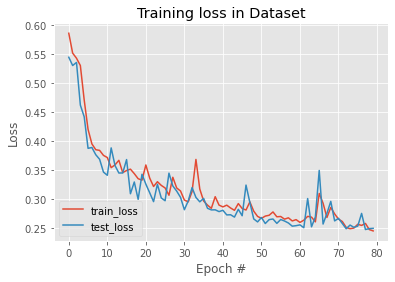

In [16]:
plt.style.use('ggplot')
plt.figure()
plt.plot(H["train_loss"], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training loss in Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig(config.BASE_OUTPUT + "/loss_graph#" + str(latest_model_number) + "_cost:{:2.4f}".format(H['test_loss'][-1]) +'.png')